## Stacking and averaging models on the Kaggle House Price dataset

This notebook presents the I did on the HousePrice Kaggle challenge. The best score (RMSE) I achieved was 0.11890 which corresponds to top 13%/14% of the current ladder.
Here it is the table of content of the project:

1. NA's Recoding
2. Data viz
3. Feature engeenering & category re-encoding
4. Train test split
5. Outlier detection (Isolation Forest)
6. Skewness and Kurthosis analysis
7. Yeo Jonhson & log transformation 
8. Fit the base learners, fine tune them, and analysis of residuals (XGBoost, Random Forest, ElasticNet, SVR)
9. Fit the metalearner, fine tune them, and analysis of residuals (Small Neural Network)
10. Average the most uncorrelated models




I linked in the different parts some links that helped me to better understand some techniques or some ML algorithm. 
A special thanks to those Kaggle notebooks which helped me with the feature engeenering :
* https://www.kaggle.com/clustersrus/house-prices-dealing-with-the-missing-data
* https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset


### Packages import

In [1]:
# Data handling
import pandas as pd
import numpy as np



# Data viz
import seaborn as sns
import matplotlib.pyplot as plt

#Machine Learning
from sklearn import linear_model
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder,RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import kurtosis, skew
from sklearn.preprocessing import power_transform
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
import scipy.stats as stats
import random
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import cross_val_predict

# Outliers detection
from sklearn.ensemble import IsolationForest

#Others
import random
import warnings

#Set seed for reproductibility
np.random.seed(1)

#Ignore warnings
warnings.filterwarnings("ignore")

## 1)  Na's recoding

In [2]:
data = pd.read_csv('train.csv')
#Removing all the lines where the labels (SalePrice) is not defined
data = data[data['SalePrice'].isna() == False]

def Change_index(data):
    """ Change the index of the df and delete the ID column"""
    data.index = data['Id']
    data = data.drop('Id',axis = 1)
    return data

data = Change_index(data)


#Size of the data set
n , k = data.shape
print("The dataset contains " + str(n) + " observations and " + str(k) + " variables")


The dataset contains 1460 observations and 80 variables


In [3]:
data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Na's recoding

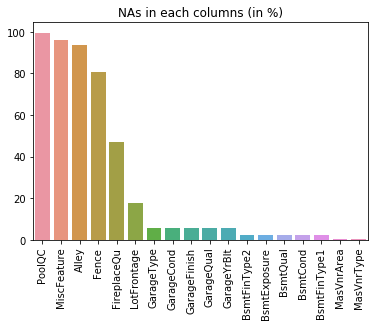

In [4]:
#Na's qty
miss_val = data.isna().sum()/n*100 #Percentage of missing values by variables
miss_val = miss_val.sort_values(ascending=False)
miss_val = miss_val[miss_val.values > 0.5]
ax =sns.barplot(x = miss_val.index, y = miss_val.values);
plt.title('NAs in each columns (in %)')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

Some variables can be coded as NA for some other reason than a missing value (for example a pool area of 0 square meters means that the house has no pool, it seems interesting to have a "NoPool" factor rather as a NA in the PoolQC column). We recode them thanks to the data dictionnary. 

In [5]:
def Manual_NA_correction(data):
    # Pool Variable: If PoolQC = NA and PoolArea = 0 , assign factor NoPool
    cond1 = (data['PoolQC'].isna() == True)
    cond2 = (data['PoolArea'] == 0)
    var = 'PoolQC'
    data.loc[ cond1 & cond2 ,var] ='No'

    # MiscFeature Variable: If MiscFeature = NA and MiscVal = 0, assign factor No
    cond1 = (data['MiscFeature'].isna() == True)
    cond2 = (data['MiscVal'] == 0)
    var = 'MiscFeature'
    data.loc[ cond1 & cond2 ,var] ='No'

    # Alley Variable: If Alley = NA, assign factor NoAccess
    var = 'Alley'
    cond1 = (data[var].isna() == True)
    data.loc[ cond1,var] ='No'

    # Fence Variable: If Fence = NA, assign factor NoFence
    var = 'Alley'
    cond1 = (data[var].isna() == True)
    data.loc[ cond1,var] ='No'

    # FireplaceQu Variable: If FireplaceQu = NA and Fireplaces = 0 , assign factor NoFirePlace
    var = 'FireplaceQu'
    cond1 = (data[var].isna() == True)
    cond2 = (data['Fireplaces'] == 0)
    data.loc[ cond1 & cond2 ,var] ='No'

    # GarageYrBlt Variable: If GarageYrBlt = NA and GarageArea = 0 assign factor NoGarage
    var = 'GarageYrBlt'
    cond1 = (data[var].isna() == True)
    cond2 = (data['GarageArea'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0

    # GarageFinish Variable: If GarageFinish = NA and GarageArea = 0 assign factor NoGarage
    var = 'GarageFinish'
    cond1 = (data[var].isna() == True)
    cond2 = (data['GarageArea'] == 0)
    data.loc[ cond1 & cond2 ,var] ='No'

    # GarageQual Variable: If GarageQual = NA and GarageArea = 0 assign factor NoGarage
    var = 'GarageQual'
    cond1 = (data[var].isna() == True)
    cond2 = (data['GarageArea'] == 0)
    data.loc[ cond1 & cond2 ,var] ='No'

    # GarageCond Variable: If GarageCond = NA and GarageArea = 0 assign factor NoGarage
    var = 'GarageCond'
    cond1 = (data[var].isna() == True)
    cond2 = (data['GarageArea'] == 0)
    data.loc[ cond1 & cond2 ,var] ='No'

    # GarageType Variable: If GarageType = NA and GarageArea = 0 assign factor NoGarage    
    var = 'GarageType'
    cond1 = (data[var].isna() == True)
    cond2 = (data['GarageArea'] == 0)
    data.loc[ cond1 & cond2 ,var] ='No'

    # BsmtFullBath Variable: If BsmtFullBath = NA and TotalBsmtSF = 0 assign 0 
    var = 'BsmtFullBath'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0 

    # BsmtHalfBath Variable: If BsmtHalfBath = NA and TotalBsmtSF = 0 assign 0   
    var = 'BsmtHalfBath'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0 

    # BsmtFinSF1 Variable: If BsmtFinSF1 = NA and TotalBsmtSF = 0 assign 0
    var = 'BsmtFinSF1'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0 

    # BsmtFinSF2 Variable: If BsmtFinSF2 = NA and TotalBsmtSF = 0 assign 0
    var = 'BsmtFinSF2'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0 

    # BsmtUnfSF Variable: If BsmtUnfSF = NA and TotalBsmtSF = 0 assign 0
    var = 'BsmtUnfSF'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0

    # TotalBsmtSF Variable: If TotalBsmtSF = NA and TotalBsmtSF = 0 assign 0
    var = 'TotalBsmtSF'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = 0

    # BsmtQual Variable: If BsmtQual = NA and TotalBsmtSF = 0 assign factor NoBasement
    var = 'BsmtQual'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = "No"

    # BsmtFinType1 Variable: If BsmtFinType1 = NA and TotalBsmtSF = 0 assign factor NoBasement
    var = 'BsmtFinType1'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = "No"

    # BsmtFinType2 Variable: If BsmtFinType2 = NA and TotalBsmtSF = 0 assign factor NoBasement
    var = 'BsmtFinType2'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = "No"

    # BsmtExposure Variable: If BsmtExposure = NA and TotalBsmtSF = 0 assign factor NoBasement
    var = 'BsmtExposure'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = "No"

    # BsmtCond Variable: If BsmtCond = NA and TotalBsmtSF = 0 assign factor NoBasement    
    var = 'BsmtCond'
    cond1 = (data[var].isna() == True)
    cond2 = (data['TotalBsmtSF'] == 0)
    data.loc[ cond1 & cond2 ,var] = "No"

    # Fence Variable: If Fence = NA, assign factor NoFence
    var = 'Fence'
    cond1 = (data[var].isna() == True)
    data.loc[ cond1 ,var] = "No"


    #Change type of MSSubclass
    data['MSSubClass'] = data['MSSubClass'].astype(str)
    return(data)

data = Manual_NA_correction(data)



#### Final NA quantity

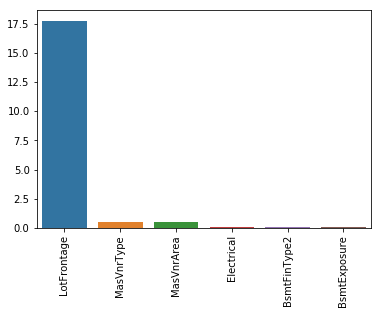

In [6]:
#Na's qty
miss_val = data.isna().sum()/n*100 #Percentage of missing values by variables
miss_val = miss_val.sort_values(ascending=False)
ax =sns.barplot(x = miss_val[miss_val.values != 0].index, y = miss_val[miss_val.values != 0].values);
ax.set_xticklabels(ax.get_xticklabels(),rotation=90);

### 2) Data visualization

#### Correlation matrix for numeric independant variables

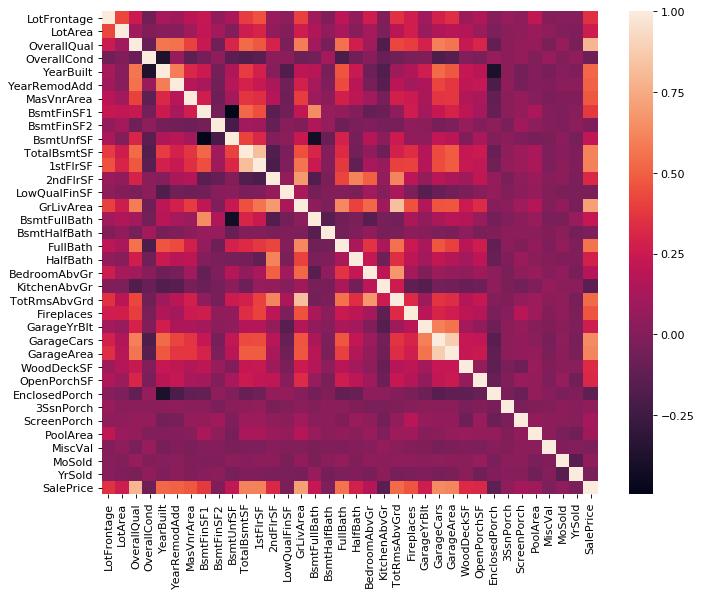

In [7]:
corrMatrix = data.corr()
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
sns.heatmap(corrMatrix, annot=False)

#### Pairplot plot for numeric independant variables 

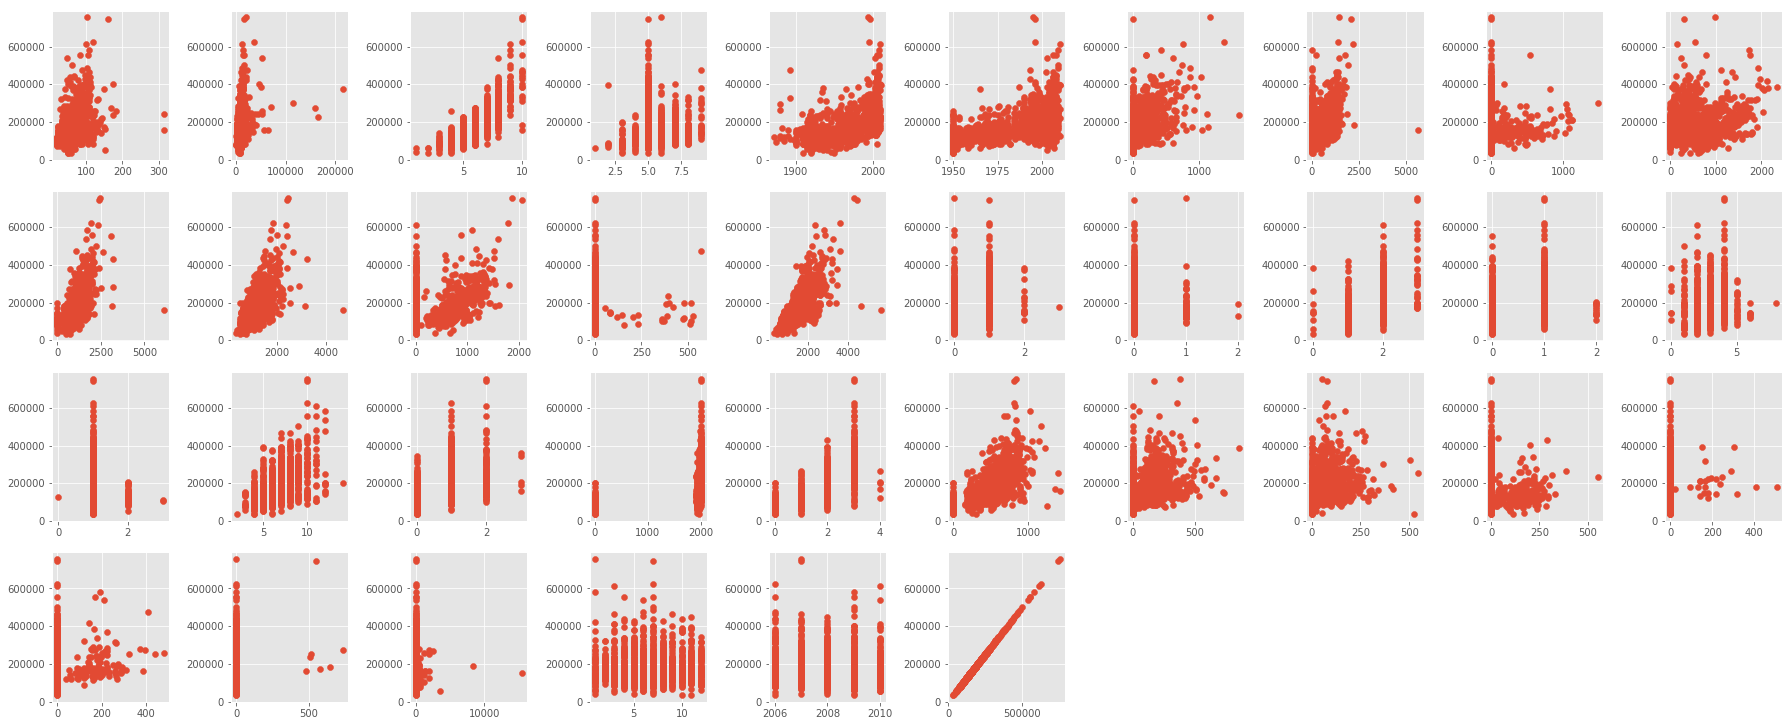

In [8]:
num = data.select_dtypes(include = ['int64','float64']).columns
plt.style.use('ggplot')
f = plt.figure(figsize = (25,25))
for i in range(len(num)):
    plt.subplot(10,10,i + 1)
    ax = plt.scatter(data[num[i]][data[num[i]].isnull() == False],data['SalePrice'][data[num[i]].isnull() == False])


plt.tight_layout()

We can observe some relationoship which are not necessarly linear (for example exp/quadratic for the first variable or log/root for the 12th one). We will add later some polynomials roots features to the dataset 

#### Boxplot for the dependant variable in function of the categories

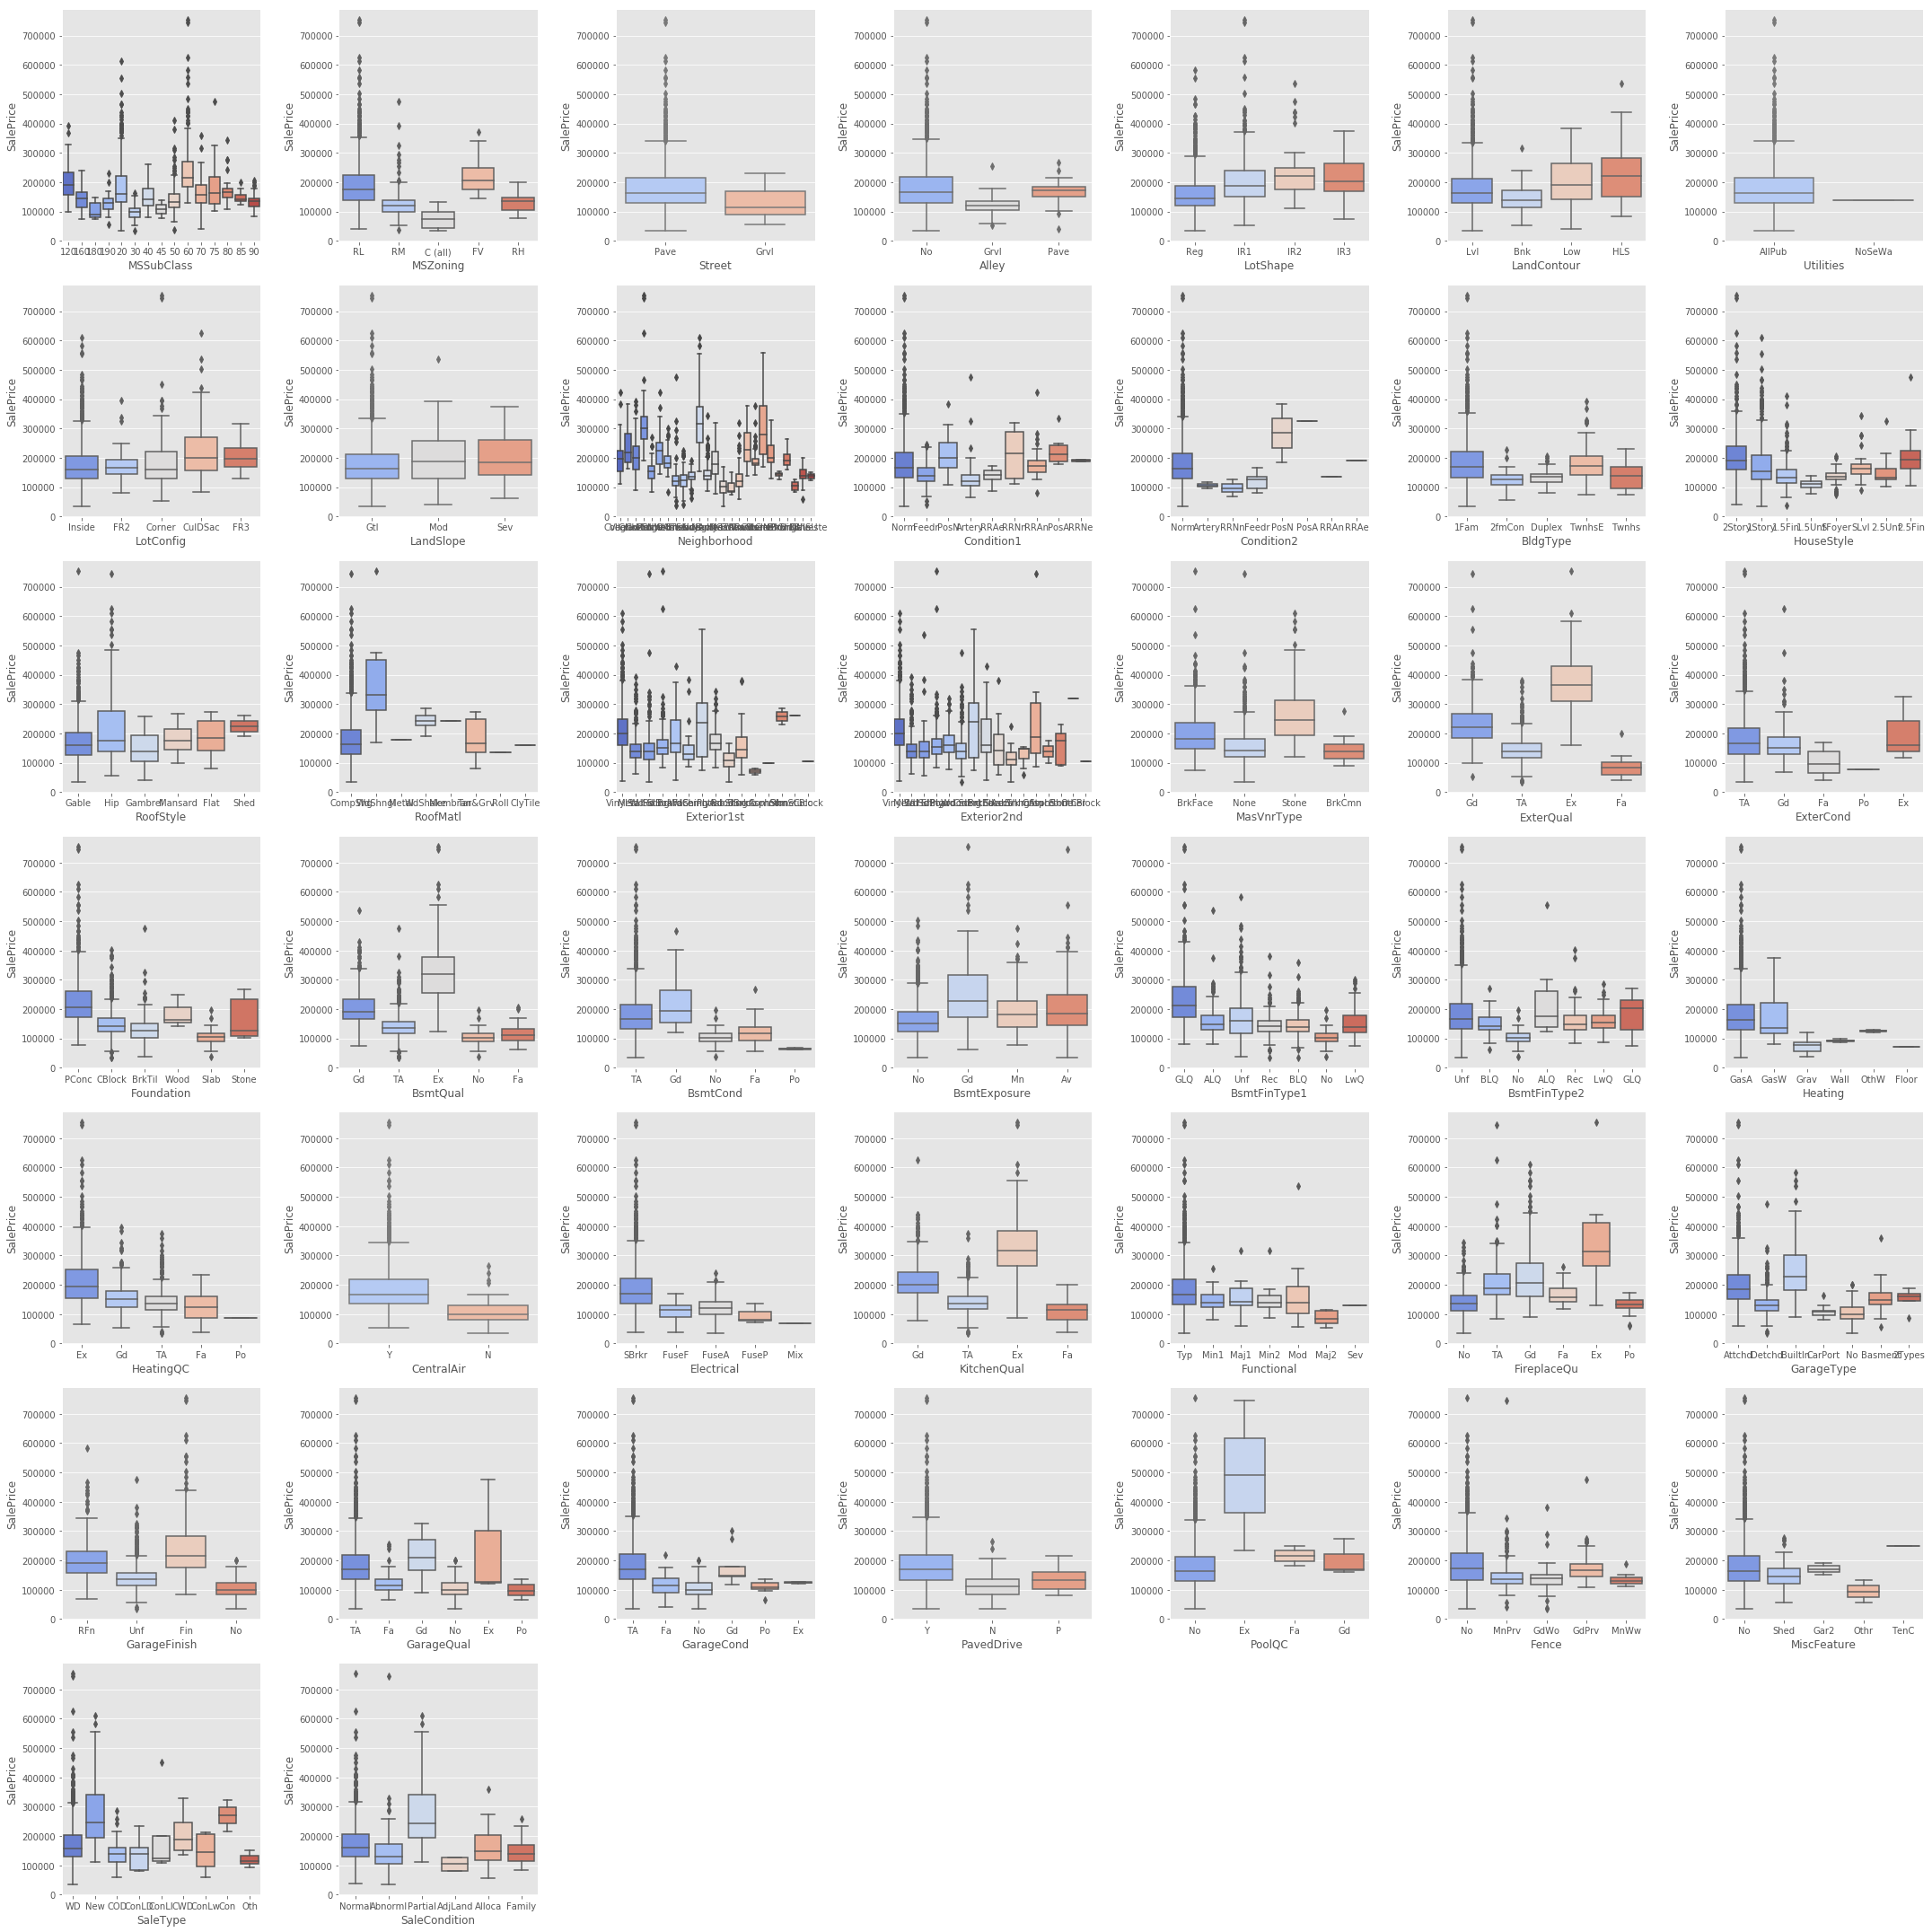

In [9]:
## Categorical values

cat = data.select_dtypes(exclude = ['int64','float64']).columns
plt.style.use('ggplot')
f = plt.figure(figsize = (30,30))
for i in range(len(cat)):
    plt.subplot(7,7,i + 1)
    ax = sns.boxplot(x=cat[i],y="SalePrice",data=data, palette="coolwarm")


plt.tight_layout()

We can see that some categorical variables are ordinal in some ways (eg. Lot Shape). We will them into integers to reduce the numbers of hot encoded vectors (dummy variables) in our future training set.

### 3) Feature engeenering & category re-encoding

In [10]:

def manual_features(data):
    
    data = data.replace({"MSSubClass" : {20 : "SC20", 30 : "SC30", 40 : "SC40", 45 : "SC45", 
                                       50 : "SC50", 60 : "SC60", 70 : "SC70", 75 : "SC75", 
                                       80 : "SC80", 85 : "SC85", 90 : "SC90", 120 : "SC120", 
                                       150 : "SC150", 160 : "SC160", 180 : "SC180", 190 : "SC190"}})
    
    # Encode some categorical features as ordered numbers when there is information in the order
    data = data.replace({"Alley" : {"Grvl" : 1, "Pave" : 2,'No' :0},
                       "BsmtCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "BsmtExposure" : {"No" : 0, "Mn" : 1, "Av": 2, "Gd" : 3},
                       "BsmtFinType1" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtFinType2" : {"No" : 0, "Unf" : 1, "LwQ": 2, "Rec" : 3, "BLQ" : 4, 
                                         "ALQ" : 5, "GLQ" : 6},
                       "BsmtQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA": 3, "Gd" : 4, "Ex" : 5},
                       "ExterCond" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "ExterQual" : {"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                       "FireplaceQu" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "Functional" : {"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                       "Min2" : 6, "Min1" : 7, "Typ" : 8},
                       "GarageCond" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "GarageQual" : {"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "HeatingQC" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "KitchenQual" : {"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                       "LandSlope" : {"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                       "LotShape" : {"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
                       "PavedDrive" : {"N" : 0, "P" : 1, "Y" : 2},
                       "PoolQC" : {"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
                       "Street" : {"Grvl" : 1, "Pave" : 2},
                       "Utilities" : {"ELO" : 1, "NoSeWa" : 2, "NoSewr" : 3, "AllPub" : 4}}
                     )
    
    
    # Overall quality of the house
    
    data["OverallGrade"] = data["OverallQual"] * data["OverallCond"]
    # Overall quality of the garage
    
    # Overall quality of the exterior
    
    data["ExterGrade"] = data["ExterQual"] * data["ExterCond"]
    # Overall kitchen score
    
    data["KitchenScore"] = data["KitchenAbvGr"] * data["KitchenQual"]
    # Overall fireplace score
    
    data["FireplaceScore"] = data["Fireplaces"] * data["FireplaceQu"]
    # Overall garage score
    
    data["GarageScore"] = data["GarageArea"] * data["GarageQual"]
    
    # Overall pool score
    data["PoolScore"] = data["PoolArea"] * data["PoolQC"]


    # Total yard area in square feet
    data["TotalPorchSF"] = data["OpenPorchSF"] + data["EnclosedPorch"] +\
                                    data["3SsnPorch"] + data["ScreenPorch"]
    # Total SF for house (living, basement, porch, pool)
    data["AllSF"] = data["GrLivArea"] + data["TotalBsmtSF"] + \
                             data["TotalPorchSF"] + data["WoodDeckSF"] + \
                             data["PoolArea"]


    data['TotalArea'] = data['TotalBsmtSF'] + data['1stFlrSF'] + data['2ndFlrSF'] + data['GrLivArea'] +data['GarageArea']

    data['Bathrooms'] = data['FullBath'] + data['HalfBath']*0.5 

    data['Year average']= (data['YearRemodAdd'] + data['YearBuilt'])/2
    return(data)
data = manual_features(data)

#### Adding Polynomials

To not create too much variables, we will just create polynomials variables for the 10 most correlated variables to SalePrice

In [11]:

corr = data.corr().abs()
corr.sort_values(["SalePrice"], ascending = False, inplace = True)
top = corr.SalePrice.iloc[0:10]
top

SalePrice      1.000000
TotalArea      0.801018
OverallQual    0.790982
AllSF          0.780088
GrLivArea      0.708624
ExterQual      0.682639
KitchenQual    0.659600
GarageCars     0.640409
GarageScore    0.624572
GarageArea     0.623431
Name: SalePrice, dtype: float64

In [12]:

def add_poly(data,columns):
    for cols in columns:
        data[cols + '_square'] = data[cols] * data[cols]
        data[cols + '_cube'] = data[cols] * data[cols] * data[cols]
        data[cols + '_sqrt'] = np.sqrt(data[cols])
    return(data)

data = add_poly(data, top.iloc[1:].index)

### 4) Train/Test split

In [13]:
from sklearn.model_selection import train_test_split
Xtrain_inline, Xtest_inline, ytrain_inline, ytest_inline = train_test_split(data.drop("SalePrice",axis = 1), data['SalePrice'], test_size=0.2, random_state=2000)
train_data = pd.concat([Xtrain_inline,ytrain_inline],axis=1)


### 5) Outlier detection with isolation forest

Text(0.5,1,'Total Area vs SalePrice')

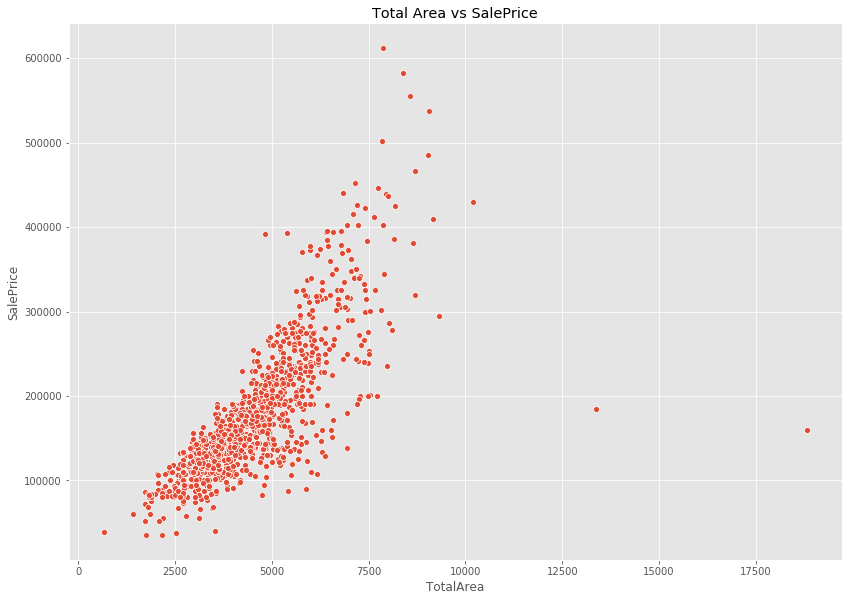

In [14]:
sns.pairplot(x_vars="TotalArea",y_vars="SalePrice",data = train_data, height=8.27, aspect=11.7/8.27);
plt.title('Total Area vs SalePrice')

We can see that Total Area of house has a clear linear/polynomial relationship with the price of it. However we can see that some datapoints which seems not to make part of the univariate and bivariate (and maybe multivariate) distribution. Those points can be a problem for the different regression algorithms. We will delete them using a density based algorithm : an isolation forest. 

#### Isolation forest

The isolation forest is an algorithm which tries to separate "anomalous" data points from the other points. To do this it fit several decision trees. This decision trees,  at each nodes, split the data with a random value (between min and max) of a random chosen variable. The trees stop growing when all the datapoints are isolating (or if we choose to prune the trees to a defined max depth). For each points we can compute a score taking into account the average number of split which was necessary to isolate it on the each trees. Intuitively a point which needs less split in average to be isolated can be presumed as outlier.

Interesting links : 
* https://towardsdatascience.com/outlier-detection-with-isolation-forest-3d190448d45e
* https://en.wikipedia.org/wiki/Isolation_forest

In [15]:
numeric_features = train_data.select_dtypes(include = ['float64',"int64"]).columns
categorical_features = train_data.select_dtypes(include = ["object"]).columns
    
def Preproc_if(df, numeric_features, categorical_features, 
               cont_imp_type = 'mean' ,cat_imp_type = 'most_frequent'):
    
    """Impute the categorical and continuous variables and hot-encode
    the categorical ones for using the isolation forest"""
    
    #Transform the numeric features and impute them with the mean 
    numeric_transformer = Pipeline(steps = [('imputer',
                                             SimpleImputer(strategy=cont_imp_type))])
    
    
    #Transform the categorical values in hot encoded vectors and impute the missing categories by the most frequent
   
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy=cat_imp_type)),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])#Personal note : For the hot encoding that will automatically fit to the test set without reordering the index 

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return(preprocessor)



#We preprocess the train_data
prepr = Preproc_if(train_data, numeric_features ,categorical_features)
imputed_data = pd.DataFrame(prepr.fit_transform(train_data),index =train_data.index ,columns = numeric_features.tolist() + prepr.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist())

#We preprocess the entire dataset and keep it for later 
#(When we will make our final predictions we will need to remove outliers on the entire dataset)
prepr2 = Preproc_if(data, numeric_features ,categorical_features)
imputed_entire_data = pd.DataFrame(prepr2.fit_transform(data),index =data.index ,columns = numeric_features.tolist() + prepr2.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist())


In [16]:
# Sklearn implementation of the isolation forest allows us to choose the tfraction of points to consider as outlier based on the anomaly score
# I choosed 2% after some tries 
iff = IsolationForest(contamination = 0.02, n_estimators= 100)
iff.fit(imputed_data)
preds = iff.predict(imputed_data)
outliers_index = np.where(preds == -1)
train_inline = train_data.drop(train_data.index[outliers_index],axis = 0)
train_outliers = train_data.loc[train_data.index[outliers_index],:]


#We do the same thing for the entire dtaaset passing the threshold from 4% to 5%
iff = IsolationForest(contamination = 0.04, n_estimators= 100)
iff.fit(imputed_entire_data)
preds = iff.predict(imputed_entire_data)
outliers_index = np.where(preds == -1)
data_inline = data.drop(data.index[outliers_index],axis = 0)
data_outliers = data.loc[data.index[outliers_index],:]
#Note : this data will not be used before the final submission


Text(0.5,1,'Total Area vs SalePrice')

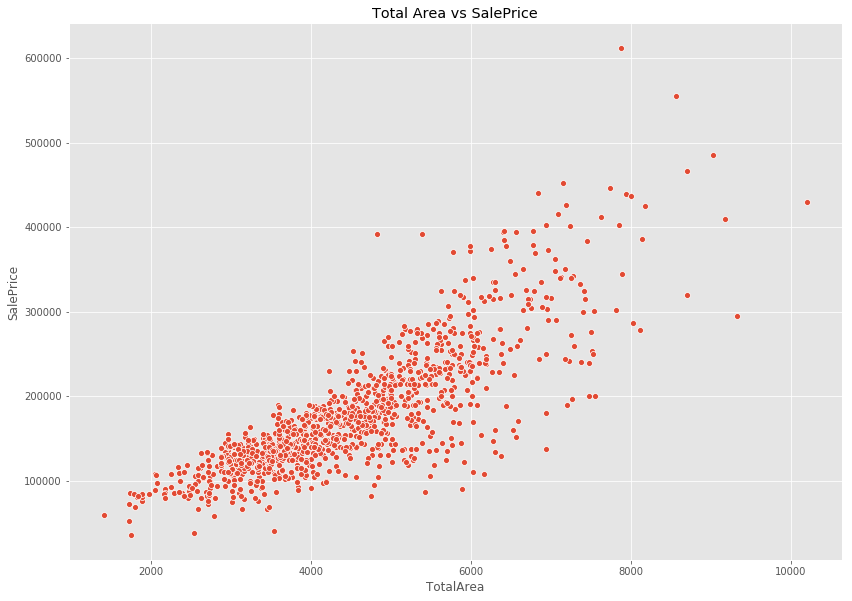

In [17]:
sns.pairplot(x_vars="TotalArea",y_vars="SalePrice",data = train_inline, height=8.27, aspect=11.7/8.27);
plt.title('Total Area vs SalePrice')

As we can see the points that we suggested anomalous have disapeared. 

In [18]:
#Re split target variable and independant variables
Xtrain_inline = train_inline.drop('SalePrice',axis =1)
ytrain_inline = train_inline['SalePrice']

#Re get the numeric features and the catgorical ones
numeric_features = Xtrain_inline.select_dtypes(include = ['float64',"int64"]).columns
categorical_features = Xtrain_inline.select_dtypes(include = ["object"]).columns
label_name = ['SalePrice']

### 6) Skewness and Kurthosis analysis 

Interesting link :
* https://www.quora.com/How-does-skewness-impact-regression-model

Skewness of the dependant variable : 1.423611335698125 
Kurthosis of the dependant variable : 2.9860809485250694 


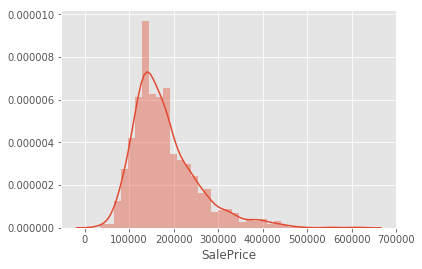

In [19]:
#Skewness and kurthosis analisys : Dependent variable

sns.distplot(ytrain_inline)
print("Skewness of the dependant variable : {} ".format(skew(ytrain_inline)))
print("Kurthosis of the dependant variable : {} ".format(kurtosis(ytrain_inline)))


As we can see target variable is moderatly right skewed and a bit heavy tailed. We will transform it to natural log to fix the problem and helps our regression algorithms.

In [20]:
#Skewness and kurthosis analisys : independant variables
a = Xtrain_inline[numeric_features].skew().abs()
b = Xtrain_inline[numeric_features].kurtosis()
skew_kurto = pd.DataFrame({"Absolute skewness" : a,"Kurtosis" : b }).sort_values(by = 'Absolute skewness',ascending = False)
skew_kurto.head()

,Absolute skewness,Kurtosis
Utilities,33.823069,1144.000000
PoolQC,26.867361,783.479360
PoolScore,26.727677,774.926246
MiscVal,22.901907,597.993692
PoolArea,19.718007,390.618167


Some of the independant variables are heavily skewed. We will try to fix this by applying a yeo jonhson transformation.

### 7) Yeo Jonhson & log transformation


####  Independant variables Y-J transformation


In [21]:
# We create the preprocessing pipelines for both numeric and categorical data.
from sklearn.preprocessing import QuantileTransformer,PowerTransformer

def YJ_scaler(imputed_dataset,numeric_features,cont_imp_type = 'mean' ,cat_imp_type = 'most_frequent'):
    
    """Scale and transform numeric variables"""
   
    numeric_transformer = Pipeline(steps=[
        ('scale',StandardScaler(with_std=False)),#Ensure that the transformation does not return infinite values
        ('yeo_john',PowerTransformer())])
    preprocessor = ColumnTransformer(
        transformers=[('num', numeric_transformer, numeric_features)])
    
    return(preprocessor)





preproc_x = YJ_scaler(Xtrain_inline,numeric_features.tolist())
preproc_x = preproc_x.fit(Xtrain_inline)
data_preproc_x = pd.DataFrame(preproc_x.transform(Xtrain_inline),index =Xtrain_inline.index,columns = numeric_features)
data_preproc_x = pd.concat([data_preproc_x,Xtrain_inline.drop(numeric_features,axis =1)],axis = 1)

####  Target variable log transformation

Skewness of the dependant variable : 0.1075807766452702 
Kurthosis of the dependant variable : 0.4836648996826196 


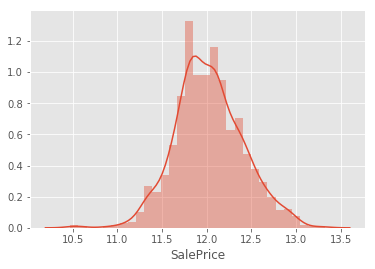

In [22]:
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

def Dependent_variable_transformation():
    label_name = ['SalePrice']
    preprocessor = FunctionTransformer(np.log1p, inverse_func = np.expm1)
    return(preprocessor,label_name)

preproc_y , label_name = Dependent_variable_transformation()
preproc_y.fit(ytrain_inline)
data_preproc_y = pd.DataFrame(preproc_y.transform(ytrain_inline),columns = label_name,index = ytrain_inline.index)
sns.distplot(data_preproc_y.SalePrice)
print("Skewness of the dependant variable : {} ".format(skew(data_preproc_y.SalePrice)))
print("Kurthosis of the dependant variable : {} ".format(kurtosis(data_preproc_y.SalePrice)))

We fixed the target distribution problem.

### 8) Fitting the base learner

In [23]:
##Useful functions for residuals analisys
def plot_residuals(model,X,y):
    preds = model.predict(X)
    residuals = np.array(y).ravel() - preds
    plt.style.use('ggplot')
    plt.plot(np.array(y).ravel(), residuals, 'bo')
    plt.title('Residual plot')
    
def qqplot_residuals(model,X,y):
    preds = model.predict(X)
    residuals = np.array(y).ravel() - preds
    norm_residuals = (residuals - np.mean(residuals))/np.std(residuals)
    plt.style.use('ggplot')
    stats.probplot(norm_residuals, dist="norm", plot=plt)
    plt.title('Residual QQplot')



#### Final data transformation

We just re do all the transformations in a unique function to re use them on the test set ansd the entire dataset (for the final prediction) 

In [24]:

def FinalImputerScaler(df): 
    
    numeric_features = df.select_dtypes(include = ['float64',"int64"]).columns
    
    numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('yeo_jonh',PowerTransformer()),
    ('scaler',StandardScaler())])

    categorical_features = df.select_dtypes(include = ["object"]).columns
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])

    preprocessor_x = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    return(preprocessor_x)





### Xs transformations
preproc_x = FinalImputerScaler(Xtrain_inline)
preproc_x = preproc_x.fit(Xtrain_inline)
data_preproc_x = pd.DataFrame(preproc_x.transform(Xtrain_inline),index = Xtrain_inline.index,columns = numeric_features.tolist() +  preproc_x.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist())
data_preproc_x_test = pd.DataFrame(preproc_x.transform(Xtest_inline),index = Xtest_inline.index,columns=numeric_features.tolist() +  preproc_x.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist())
    
### Ys transformations

data_preproc_y = np.log1p(ytrain_inline)
#Transforms the test set
data_preproc_y_test = np.log1p(ytest_inline)


### Full data transformations (used only at the end)
preproc_full_x = FinalImputerScaler(data_inline.drop('SalePrice',axis=1))
preproc_full_x = preproc_full_x.fit(data_inline.drop('SalePrice',axis=1))
data_preproc_full_x = pd.DataFrame(preproc_full_x.transform(data_inline.drop('SalePrice',axis=1)),index = data_inline.index,columns = numeric_features.tolist() +  preproc_full_x.named_transformers_['cat'].named_steps['onehot'].get_feature_names(categorical_features).tolist())
data_preproc_full_y = np.log1p(data_inline['SalePrice'])

In [25]:
from sklearn.metrics import make_scorer
def rmse(y_true, y_pred):
    diff = np.square(y_true - y_pred)
    res = np.sqrt(np.mean(diff))
    return(res)
custom = make_scorer(rmse, greater_is_better=False)


#### XGBoost fine tuning with Randomized Hyparameters Search

Intresting link to learn about Xgb : 
* https://www.youtube.com/watch?v=OtD8wVaFm6E

In [26]:
#XG BOOST FINE TUNING


model_xgb = xgb.XGBRegressor()


xgb_param_grid1 = {
    #"Factor of speed" of learning f the algorithm : the more it is, the more each weak tree give weight to the decision
    'learning_rate' : loguniform(0.001, 0.2),
    #Max deph of the trees
    'max_depth' : stats.randint(3,10),
    #Regularization parameters (in function of the sizes of the trees)
    'gamma' : stats.uniform(0, 1),
    #L2 penalization parameter
    'reg_lambda' : stats.uniform(0, 1.5),
    #L1 penalization parameter
    'reg_alpha' : stats.uniform(0, 1.5),
    #Number of trees boosters
    'n_estimator' : stats.randint(300,2800)
}
n_iter_search = 150
random_search = RandomizedSearchCV(model_xgb, param_distributions=xgb_param_grid1,n_jobs=-1,scoring=custom,verbose=1,
                                   n_iter=n_iter_search,random_state = 1)

random_search = random_search.fit(data_preproc_x, data_preproc_y)

Fitting 5 folds for each of 150 candidates, totalling 750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 750 out of 750 | elapsed:  3.2min finished


In [27]:
#I put all the parameters tested in an excel file in case i want to retake a look at them in the future 
first_iter = pd.DataFrame(random_search.cv_results_).sort_values(by ='rank_test_score').iloc[:,4:].drop(['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'],axis=1)
first_iter.to_excel('xgb_first.xlsx')
first_iter.head()


,param_gamma,param_learning_rate,param_max_depth,param_n_estimator,param_reg_alpha,param_reg_lambda,params,mean_test_score,std_test_score,rank_test_score
28,0.0719743,0.168164,7,1595,0.30494,0.378489,"{'gamma': 0.07197427968948678, 'learning_rate'...",-0.119391,0.010032,1
54,0.0670321,0.0737752,3,1993,0.566886,0.119439,"{'gamma': 0.06703205008588631, 'learning_rate'...",-0.120337,0.009113,2
95,0.160416,0.105495,8,2371,0.413205,0.0774619,"{'gamma': 0.16041638881233045, 'learning_rate'...",-0.123048,0.009600,3
96,0.138715,0.0618971,7,1744,0.875158,1.39219,"{'gamma': 0.13871462268568635, 'learning_rate'...",-0.127928,0.007054,4
67,0.143006,0.11856,8,1772,1.46211,0.954907,"{'gamma': 0.14300582825809938, 'learning_rate'...",-0.128396,0.009286,5


In [28]:
xgb_final_params = first_iter['params'].iloc[0]
xgb_final_params

{'gamma': 0.07197427968948678,
 'learning_rate': 0.16816354322951166,
 'max_depth': 7,
 'n_estimator': 1595,
 'reg_alpha': 0.3049398519914857,
 'reg_lambda': 0.3784886168554851}

In [26]:
#I hard code the hyperparameters to not re run the randomized search in the future
model_xgb = xgb.XGBRegressor(booster = "gbtree",**
{'gamma': 0.07197427968948678,
 'learning_rate': 0.16816354322951166,
 'max_depth': 7,
 'n_estimator': 1595,
 'reg_alpha': 0.3049398519914857,
 'reg_lambda': 0.3784886168554851})
model_xgb = model_xgb.fit(data_preproc_x, data_preproc_y)

s = rmse(model_xgb.predict(data_preproc_x_test),data_preproc_y_test)

print("Rmse on the test set : %s" % s)

Rmse on the test set : 0.14085819341945652


##### Final XGB model analysis

<u>Feature importance</u>

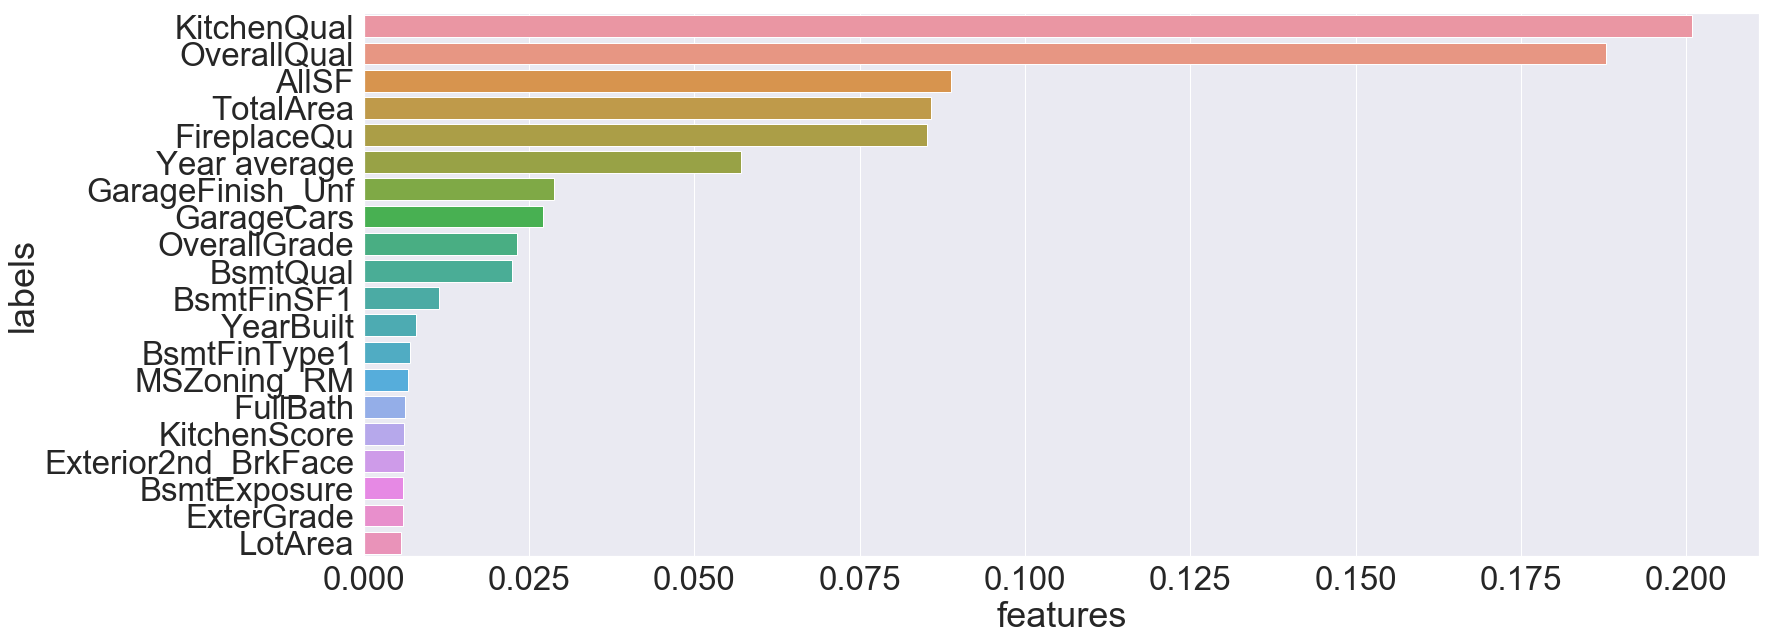

In [27]:
## Plot the variable importance for the random forest
sns.set(font_scale = 3)
a = pd.DataFrame({"labels" : data_preproc_x.columns,"features" : model_xgb.feature_importances_})
a.sort_values(by=['features'],ascending =False,inplace = True)
a = a.iloc[:20,:]
plt.rcParams["figure.figsize"] = (25,10)
sns.barplot(y="labels", x="features",data=a,orient = "h")


It seems that the overall quality of the house plays a good role in making its price. 

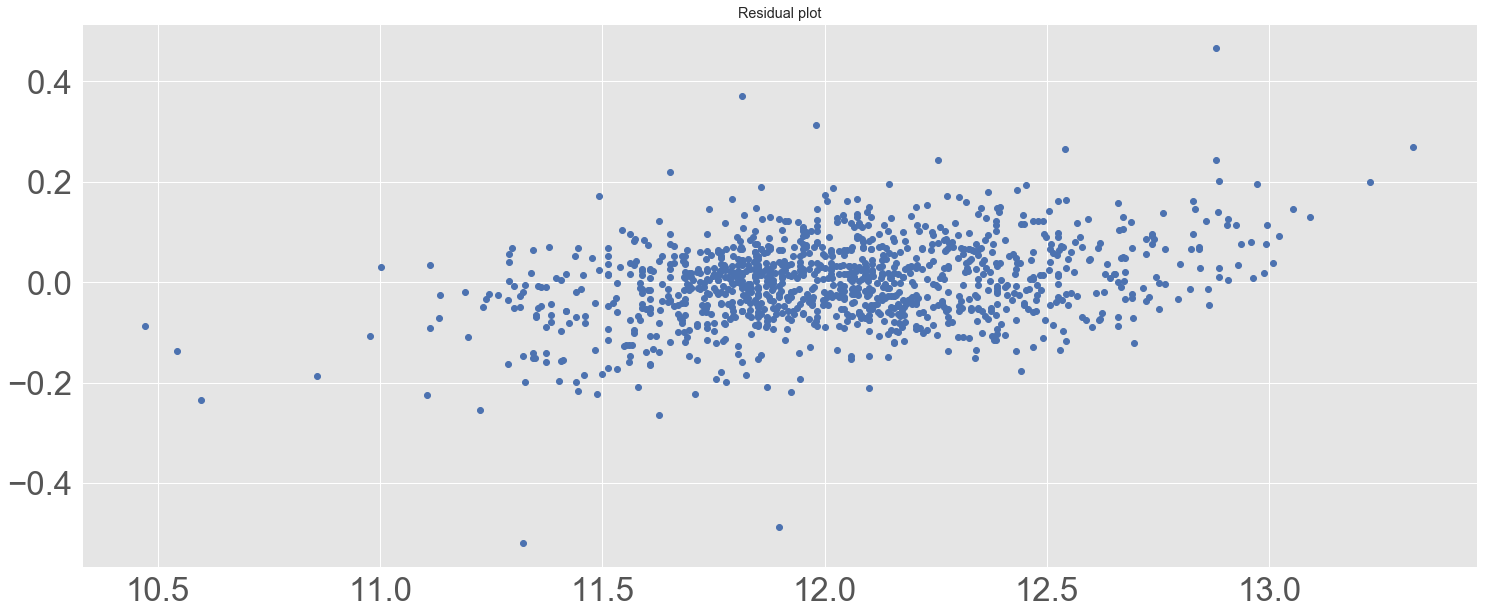

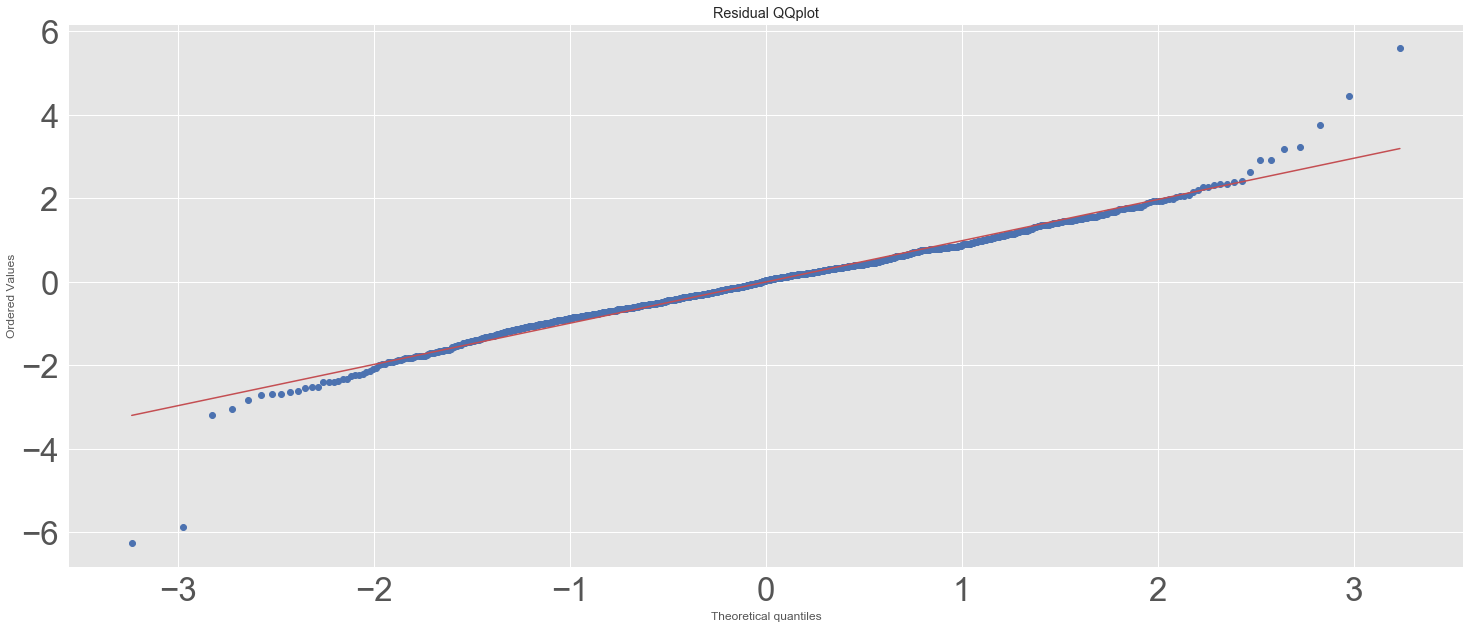

In [28]:

plot_residuals(model_xgb,data_preproc_x, data_preproc_y)
plt.show()

qqplot_residuals(model_xgb,data_preproc_x, data_preproc_y)
plt.show()

It seems that our  model does not estimate well the large and low values (residuals are not completly homoscedastic). We hope that the meta classifier will tune this. 

#### RandomForest fine tuning with Randomized Hyparameters Search

In [32]:
model_rf = RandomForestRegressor()
rf_param_dist = {#Number of trees to do
              "n_estimators" :stats.randint(800,1500),
              #Max depth of each trees
              "max_depth": stats.randint(8,20),
              #Maximum features taken by each trees (in percent)
              "max_features": stats.uniform(0.2, 1),
              #Minimum of observations to split the tree
              "min_samples_split": stats.uniform(0.2, 0.8),
              #Does the random forest has to resample with replacement ?
              "bootstrap": [True],
              #Criteria of impurity by variables to make a split
              "criterion": ["mse","mae"]}

#We use a randomized search to be more efficient
n_iter_search = 100
random_search1 = RandomizedSearchCV(model_rf, param_distributions=rf_param_dist,scoring = custom,
                                   n_iter=n_iter_search, n_jobs = -1)
random_search1 = random_search1.fit(data_preproc_x, data_preproc_y)


In [33]:
#I put all the parameters tested in an excel file in case i want to retake a look at them in the future 
first_iter = pd.DataFrame(random_search1.cv_results_).sort_values(by ='rank_test_score').iloc[:,4:].drop(['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'],axis=1)
first_iter.to_excel('RF_first.xlsx')
first_iter.head()


,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_split,param_n_estimators,params,mean_test_score,std_test_score,rank_test_score
41,True,mse,16,0.503161,0.203829,1335,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",-0.184416,0.001946,1
3,True,mse,15,0.303155,0.219618,1178,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",-0.184943,0.004211,2
99,True,mae,17,0.224035,0.272296,984,"{'bootstrap': True, 'criterion': 'mae', 'max_d...",-0.211220,0.006533,3
33,True,mse,19,0.584716,0.272833,1054,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",-0.214350,0.006058,4
97,True,mse,18,0.921762,0.294964,1389,"{'bootstrap': True, 'criterion': 'mse', 'max_d...",-0.219244,0.006267,5


In [29]:
#I hard code the hyperparameters to not re run the randomized search in the future
model_rf = RandomForestRegressor(**
{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': 16,
 'max_features': 0.5031613853492674,
 'min_samples_split': 0.20382898818832695,
 'n_estimators': 1335})
model_rf = model_rf.fit(data_preproc_x, data_preproc_y)
s = rmse(model_rf.predict(data_preproc_x_test), data_preproc_y_test)
print("Rmse on the test set : %s" % s)

Rmse on the test set : 0.2144112652109812


Our random forest does not perform quite well on the test set. We will use it anyway for the stacking. 

##### Final RF model analysis

<u>Feature importance</u>

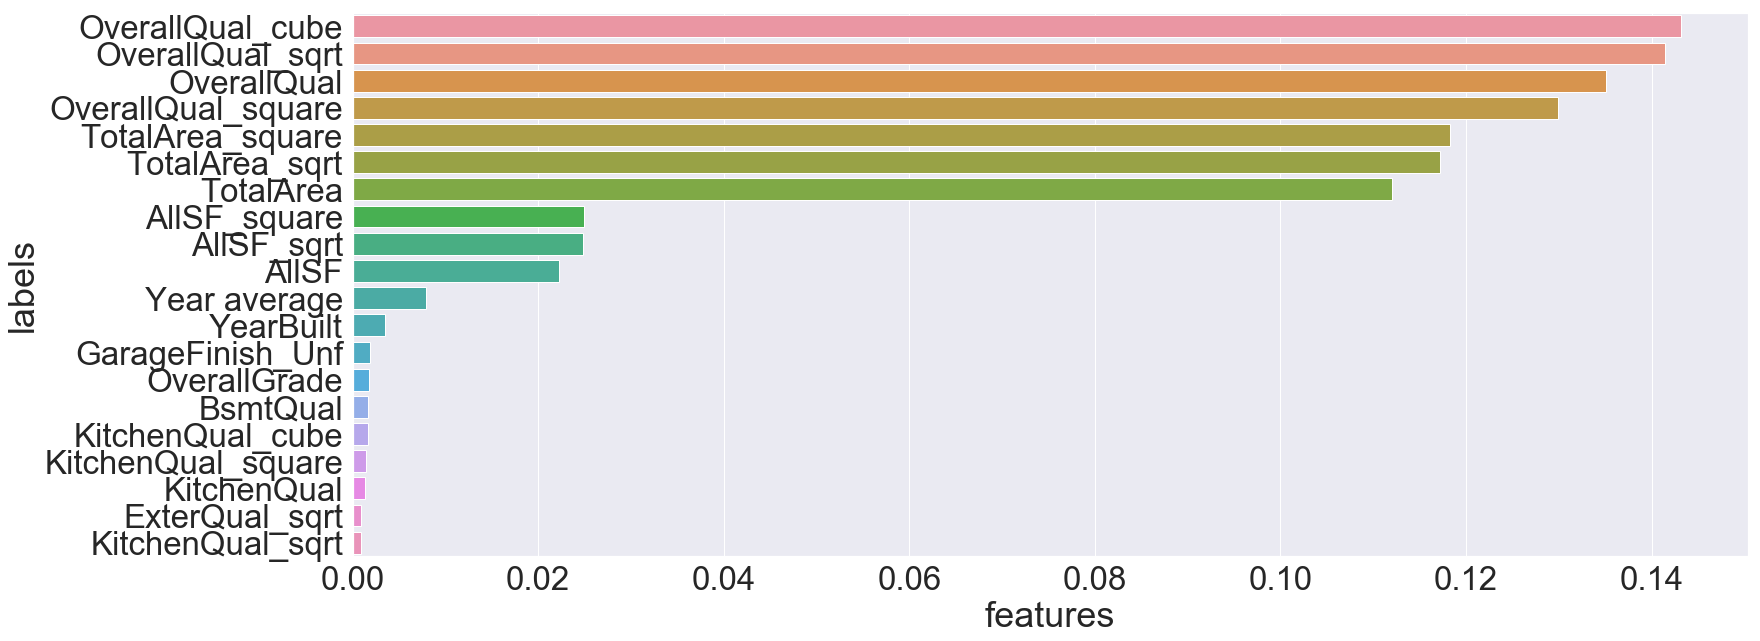

In [30]:
## Plot the variable importance for the random forest
sns.set(font_scale = 3)
a = pd.DataFrame({"labels" : data_preproc_x.columns,"features" : model_rf.feature_importances_})
a.sort_values(by=['features'],ascending =False,inplace = True)
a = a.iloc[:20,:]
plt.rcParams["figure.figsize"] = (25,10)
sns.barplot(y="labels", x="features", data=a, orient = "h")


In the same way as XGB the random forest gives more weight to the quality variables. 

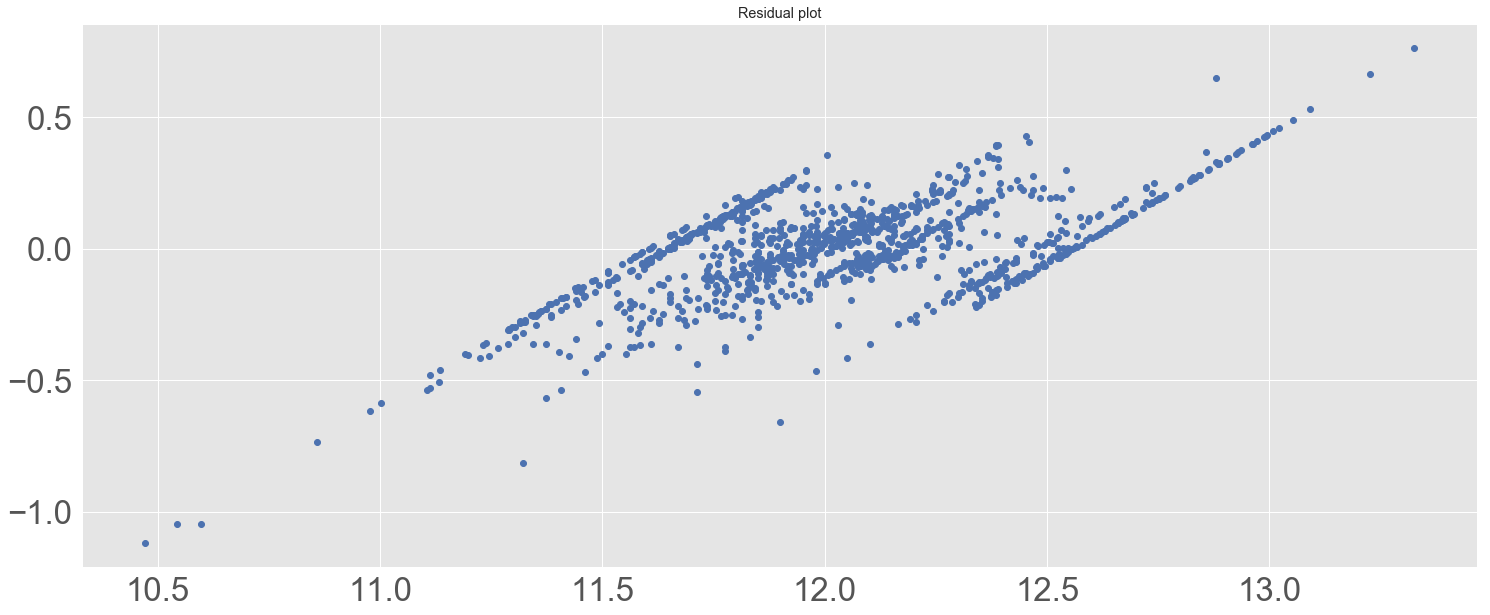

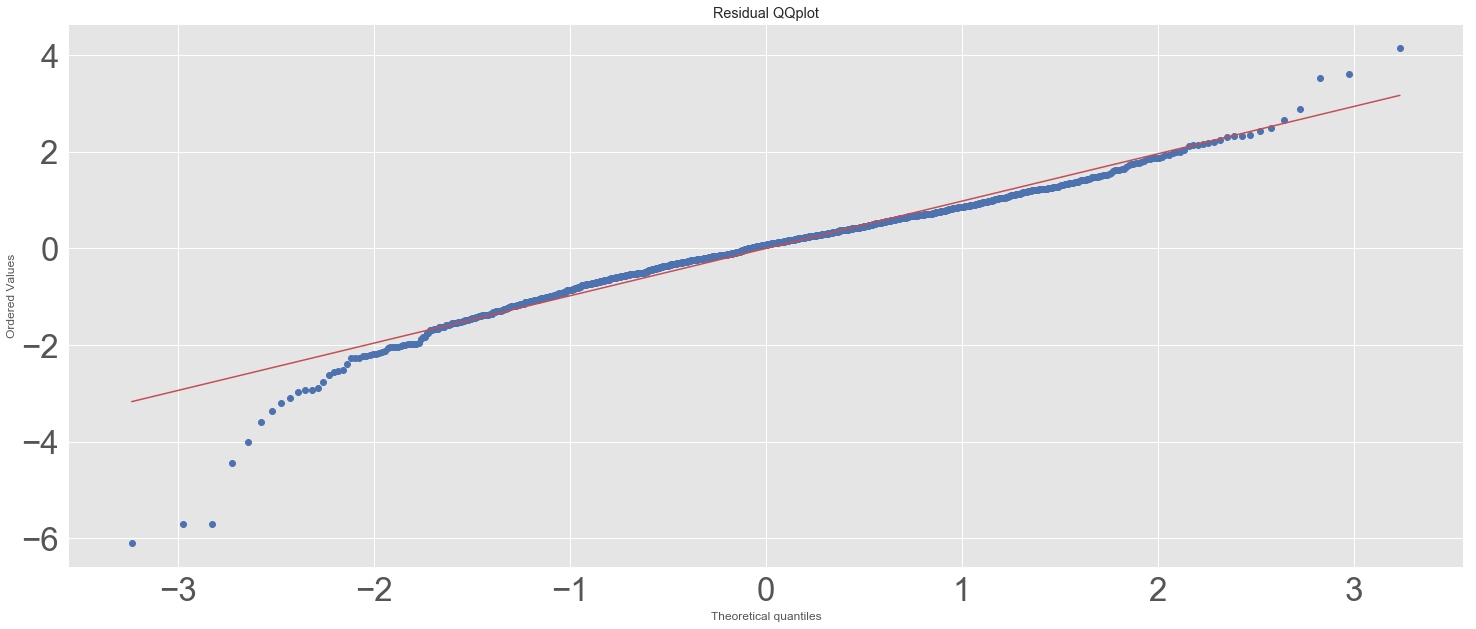

In [31]:
plot_residuals(model_rf,data_preproc_x, data_preproc_y)
plt.show()

qqplot_residuals(model_rf,data_preproc_x, data_preproc_y)
plt.show()

Same analysis than the xgb algorithm apply here, but even worse.  

#### Support Vector Machine (for regression) fine tuning with Randomized Hyparameters Search

In [37]:

model_svr = SVR()

svr_param_dist = {#Type of kernel used
              "kernel" : ['rbf','poly'],
              #"Factor of variability of the kernel" : the more it's high the less variance it is
              "gamma":loguniform(0.05, 0.5),
              #Cost (inverted) regularization parameter
              "C": loguniform(0.01,6)}

#We use a randomized grid search to be more efficient
n_iter_search = 150
random_search1 = RandomizedSearchCV(model_svr, param_distributions=svr_param_dist,scoring = custom,
                                   n_iter=n_iter_search,n_jobs=-1)
random_search1 = random_search1.fit(data_preproc_x, data_preproc_y)


In [38]:
first_iter = pd.DataFrame(random_search1.cv_results_).sort_values(by ='rank_test_score').iloc[:,4:].drop(['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'],axis=1)
first_iter.to_excel('SVR_first.xlsx')
first_iter.head()

,param_C,param_gamma,param_kernel,params,mean_test_score,std_test_score,rank_test_score
79,0.0101665,0.057615,poly,"{'C': 0.010166518296389931, 'gamma': 0.0576149...",-0.136219,0.008909,1
29,0.0131157,0.0613057,poly,"{'C': 0.013115707320876602, 'gamma': 0.0613056...",-0.136636,0.008925,2
31,0.0192479,0.0580083,poly,"{'C': 0.0192479146535253, 'gamma': 0.058008299...",-0.136963,0.008939,3
120,0.0154015,0.136547,poly,"{'C': 0.015401543385369311, 'gamma': 0.1365469...",-0.137161,0.008991,4
91,3.001,0.0600785,poly,"{'C': 3.0009970230816707, 'gamma': 0.060078464...",-0.137161,0.008988,5


In [39]:
svr_final_params = first_iter['params'].iloc[0]
svr_final_params

{'C': 0.010166518296389931, 'gamma': 0.05761499603504246, 'kernel': 'poly'}

In [32]:
model_svr = SVR(**{'C': 0.012253926406164501, 'gamma': 0.05698031892391047, 'kernel': 'poly'})
model_svr = model_svr.fit(data_preproc_x, data_preproc_y)
s = rmse(model_svr.predict(data_preproc_x_test),data_preproc_y_test)
print("Rmse on the test set : %s" % s)

Rmse on the test set : 0.16199389268580974


##### Final SVR model analysis

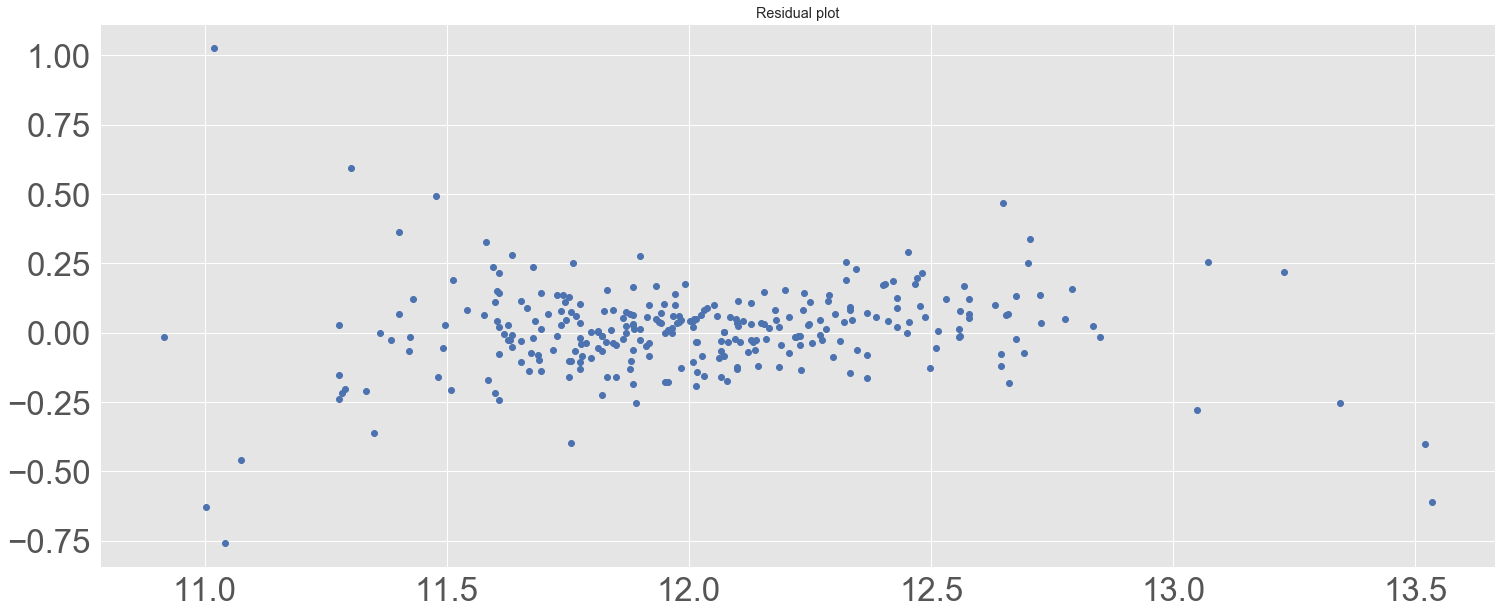

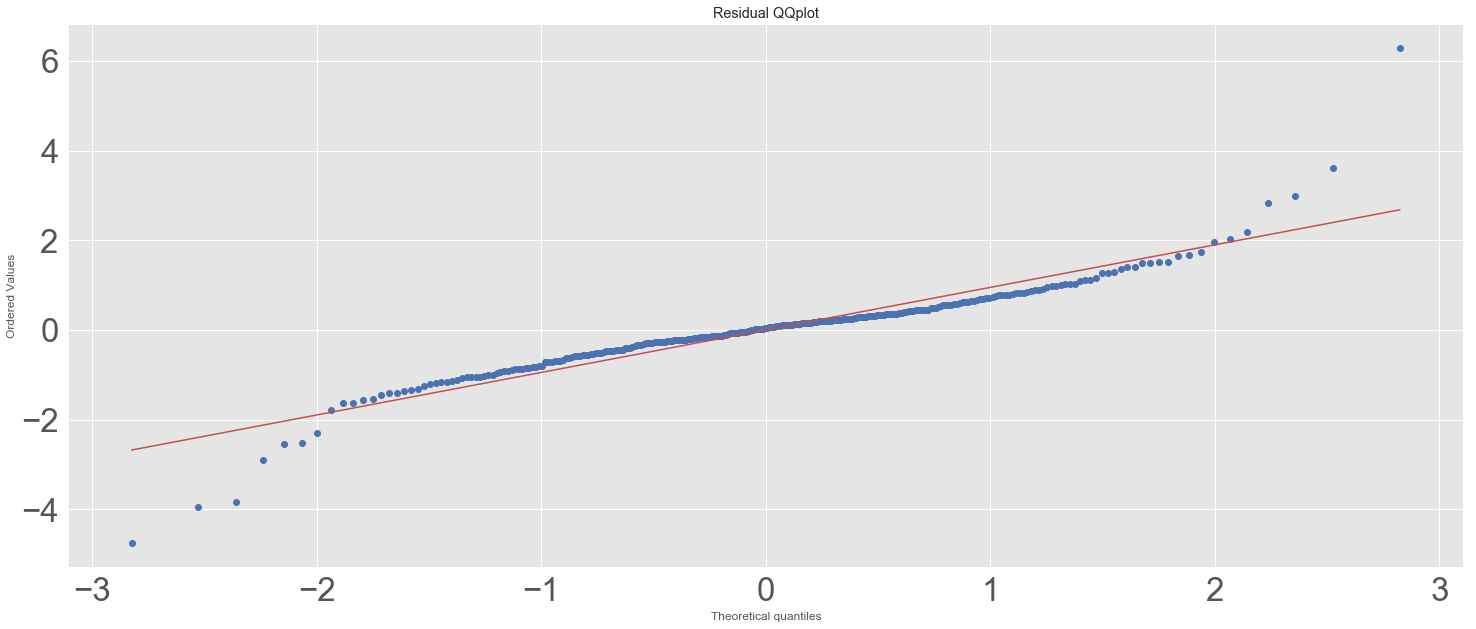

In [33]:
plot_residuals(model_svr,data_preproc_x_test, data_preproc_y_test)
plt.show()
qqplot_residuals(model_svr,data_preproc_x_test, data_preproc_y_test)
plt.show()


####  ElasticNet Regression fine tuning with Randomized Hyparameters Search

In [43]:
model_enet = ElasticNet()

enet_param_dist = {#Regularization parameter for both L1 and L2 penalization
              "alpha" : loguniform(0.01, 10),
              #"ratio L1/L2 penalization" 
              "l1_ratio":stats.uniform(0.01,1)}

#We use a randomized grid search to be more efficient
n_iter_search = 150
random_search1 = RandomizedSearchCV(model_enet, param_distributions=enet_param_dist,scoring = custom,
                                   n_iter=n_iter_search,n_jobs =-1)
random_search1 = random_search1.fit(data_preproc_x, data_preproc_y)


In [44]:
first_iter = pd.DataFrame(random_search1.cv_results_).sort_values(by ='rank_test_score').iloc[:,4:].drop(['split0_test_score','split1_test_score','split2_test_score','split3_test_score','split4_test_score'],axis=1)
first_iter.to_excel('enet_first.xlsx')
first_iter.head()

,param_alpha,param_l1_ratio,params,mean_test_score,std_test_score,rank_test_score
92,0.0110568,0.0520242,"{'alpha': 0.011056812850865983, 'l1_ratio': 0....",-0.105634,0.011738,1
42,0.0258748,0.0180899,"{'alpha': 0.02587482843076884, 'l1_ratio': 0.0...",-0.106374,0.011497,2
143,0.0111107,0.074891,"{'alpha': 0.011110682250426098, 'l1_ratio': 0....",-0.106549,0.011980,3
107,0.011186,0.166251,"{'alpha': 0.011185955504514575, 'l1_ratio': 0....",-0.110423,0.011987,4
132,0.0112537,0.194895,"{'alpha': 0.011253682868191927, 'l1_ratio': 0....",-0.111126,0.011860,5


In [45]:
enet_final_params = first_iter['params'].iloc[0]
enet_final_params

{'alpha': 0.011056812850865983, 'l1_ratio': 0.05202422054464117}

In [34]:
model_enet = ElasticNet(**{'alpha': 0.011056812850865983, 'l1_ratio': 0.05202422054464117})
model_enet = model_enet.fit(data_preproc_x, data_preproc_y)
s = rmse(model_enet.predict(data_preproc_x_test),data_preproc_y_test)
print("Rmse on the test set : %s" % s)

Rmse on the test set : 0.11949598006647881


##### Final Enet model analysis

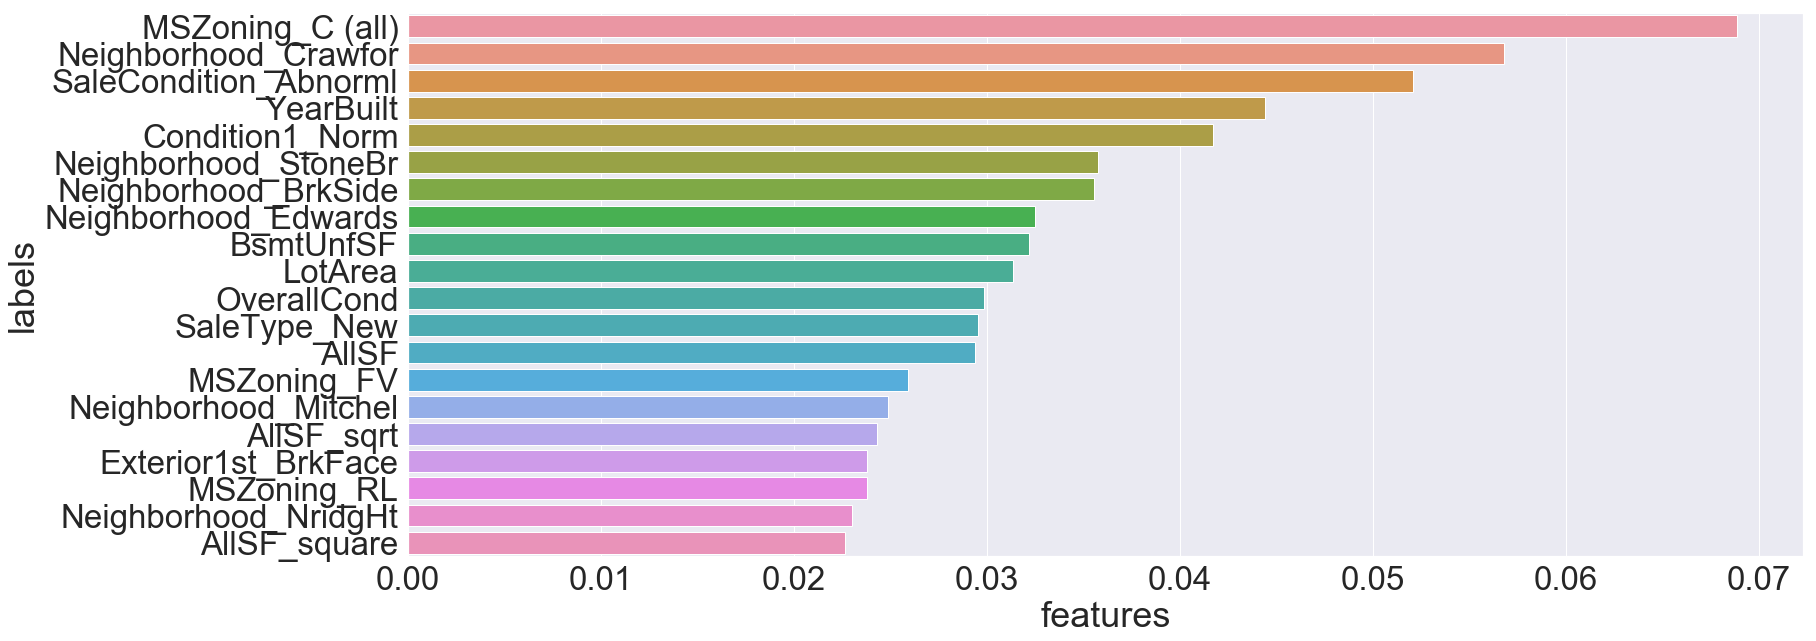

In [35]:
## Plot the variable importance for the random forest
sns.set(font_scale = 3)
a = pd.DataFrame({"labels" : data_preproc_x.columns,"features" : np.abs(model_enet.coef_)})
a.sort_values(by=['features'],ascending =False,inplace = True)
a = a.iloc[:20,:]
plt.rcParams["figure.figsize"] = (25,10)
sns.barplot(y="labels", x="features",data=a,orient = "h")


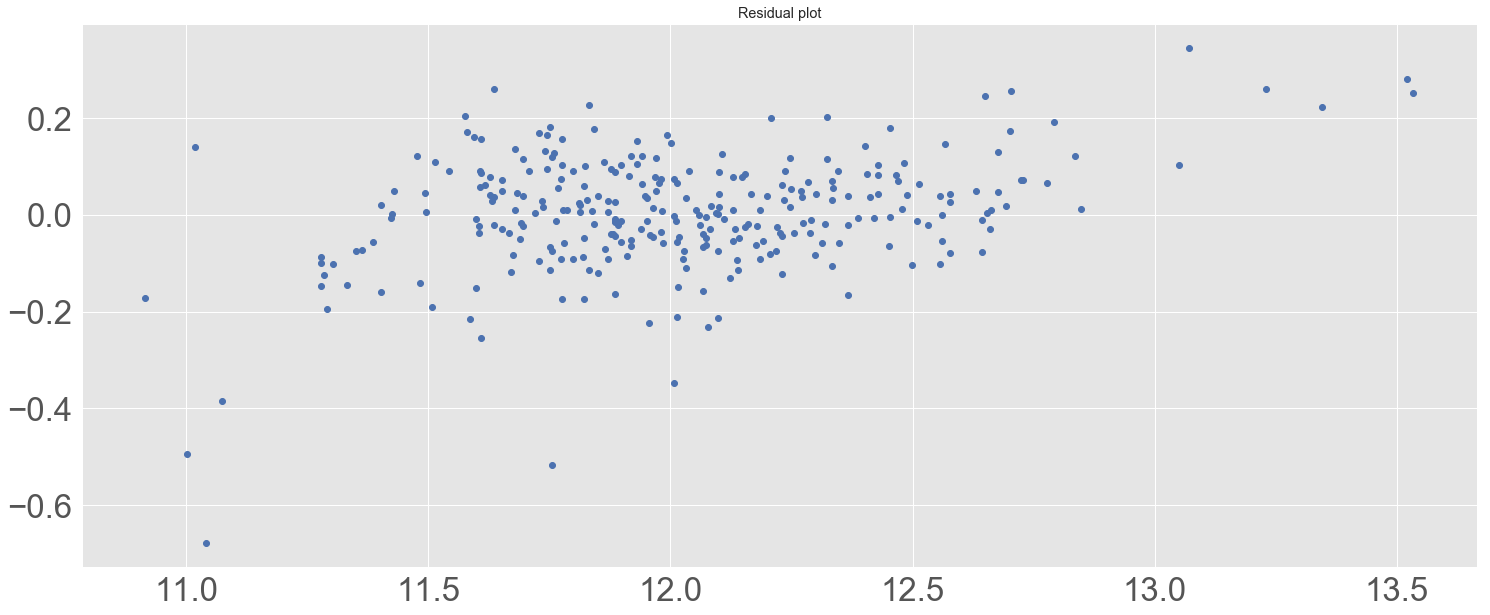

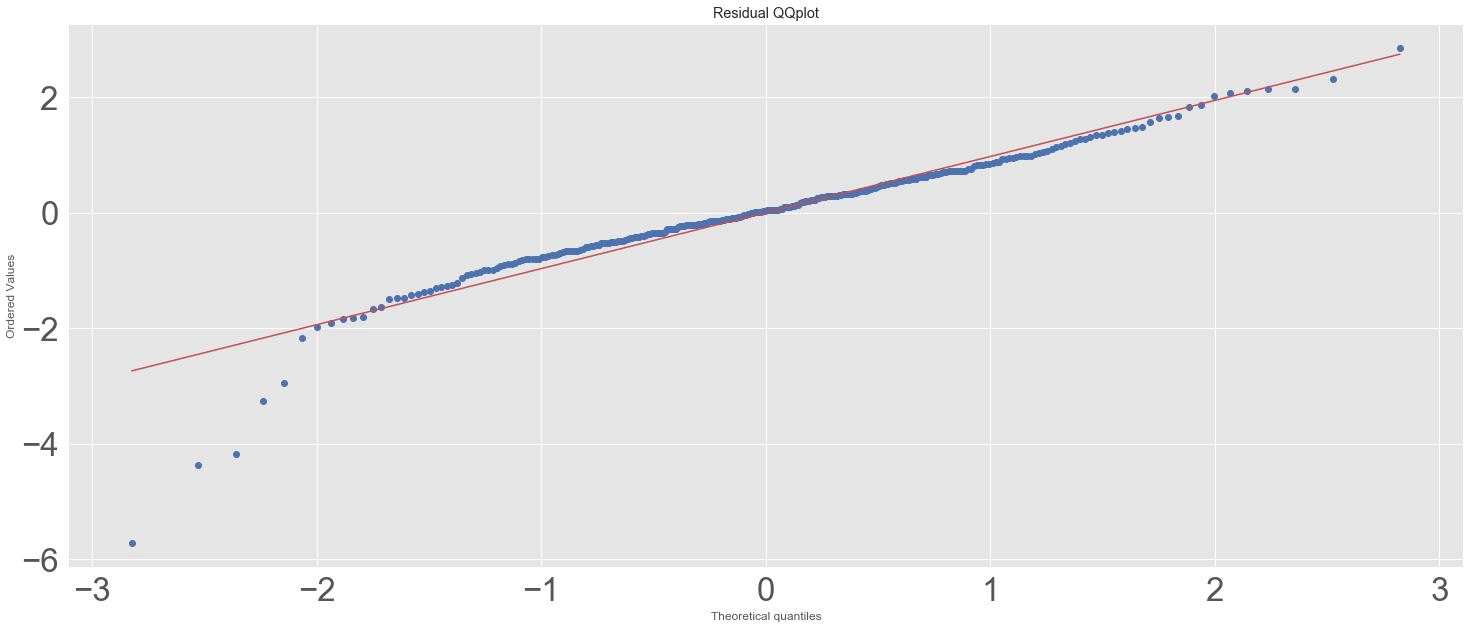

In [36]:
plot_residuals(model_enet,data_preproc_x_test, data_preproc_y_test)
plt.show()
qqplot_residuals(model_enet,data_preproc_x_test, data_preproc_y_test)
plt.show()

### 9) Fine tuning the meta learner : Multilayer Percepetron (Small NN)

Interesting links : 
* https://www.kdnuggets.com/2017/02/stacking-models-imropved-predictions.html
* https://fr.coursera.org/lecture/competitive-data-science/stacking-Qdtt6

In [37]:

preds_xgb = cross_val_predict(model_xgb,data_preproc_x,data_preproc_y)
preds_rf =  cross_val_predict(model_rf,data_preproc_x,data_preproc_y)
preds_svr = cross_val_predict(model_svr,data_preproc_x,data_preproc_y)
preds_enet = cross_val_predict(model_enet,data_preproc_x,data_preproc_y)
meta_data = np.stack([preds_xgb,preds_rf,preds_svr,preds_enet],axis = 1)



In [38]:
meta_data2 = np.concatenate([np.array(data_preproc_x),meta_data],axis = 1)

In [39]:
metalearner  = MLPRegressor(hidden_layer_sizes= (2**6,2**7),solver = 'adam',activation = 'relu',learning_rate = 'invscaling')
nn_param_dist = {
    # L2 regularization parameter
    'alpha' : loguniform(0.1,10),
    #Learning rate 
    'learning_rate_init': loguniform(0.001,1)  
}

#We use a randomized search to be more efficient
n_iter_search = 70
random_search1 = RandomizedSearchCV(metalearner, param_distributions=nn_param_dist,n_jobs = -1,verbose=1,
                                   n_iter=n_iter_search,scoring = custom)
random_search1 = random_search1.fit(meta_data2, data_preproc_y)

best_params_nn = random_search1.best_params_
metalearner = MLPRegressor(hidden_layer_sizes= (2**6,2**7),solver = 'adam',activation = 'relu',learning_rate = 'invscaling',**best_params_nn)


Fitting 5 folds for each of 70 candidates, totalling 350 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   45.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:  8.9min finished


In [40]:
base_learners = [('xgb', model_xgb),
                 ('rf', model_rf),
                ('svr', model_svr),
                ('enet',model_enet)]

final_reg = StackingRegressor(estimators = base_learners,n_jobs = -1,passthrough=True,
                          final_estimator = metalearner)
final_reg.fit(data_preproc_x,data_preproc_y)
s = rmse(final_reg.predict(data_preproc_x_test),data_preproc_y_test)
print("Rmse on the test set : %s" % s)

Rmse on the test set : 0.12403771287356867


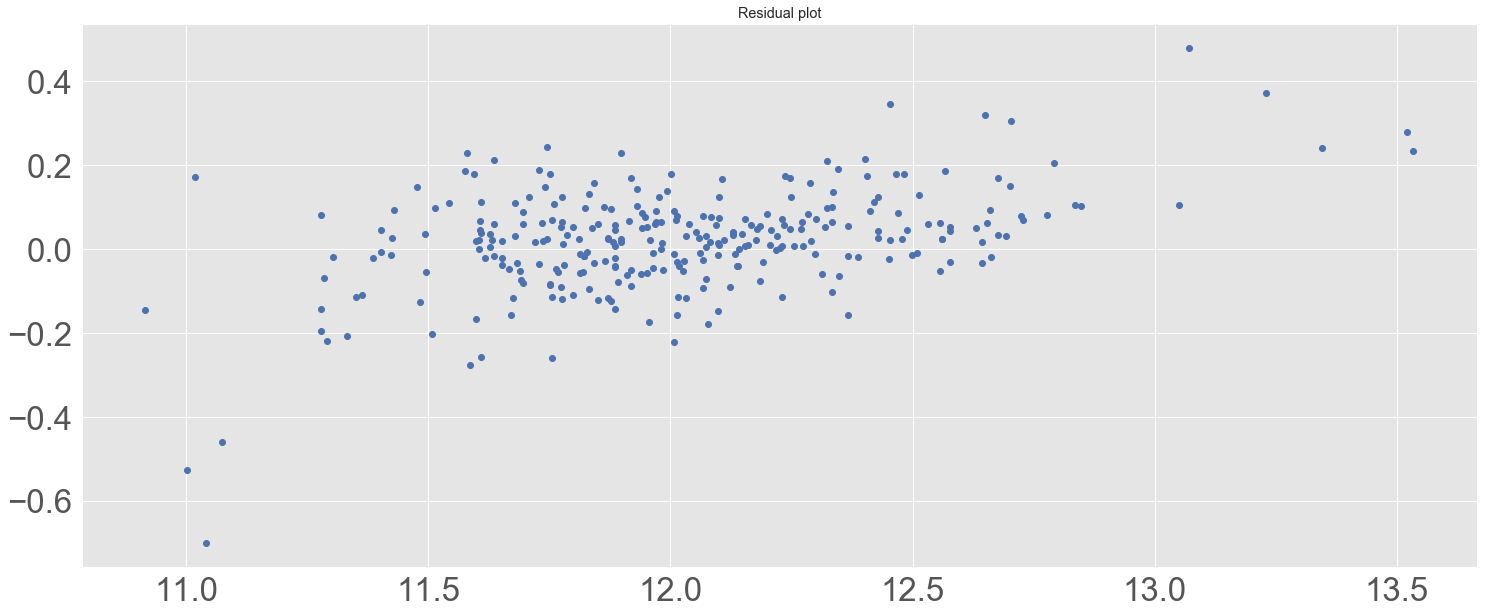

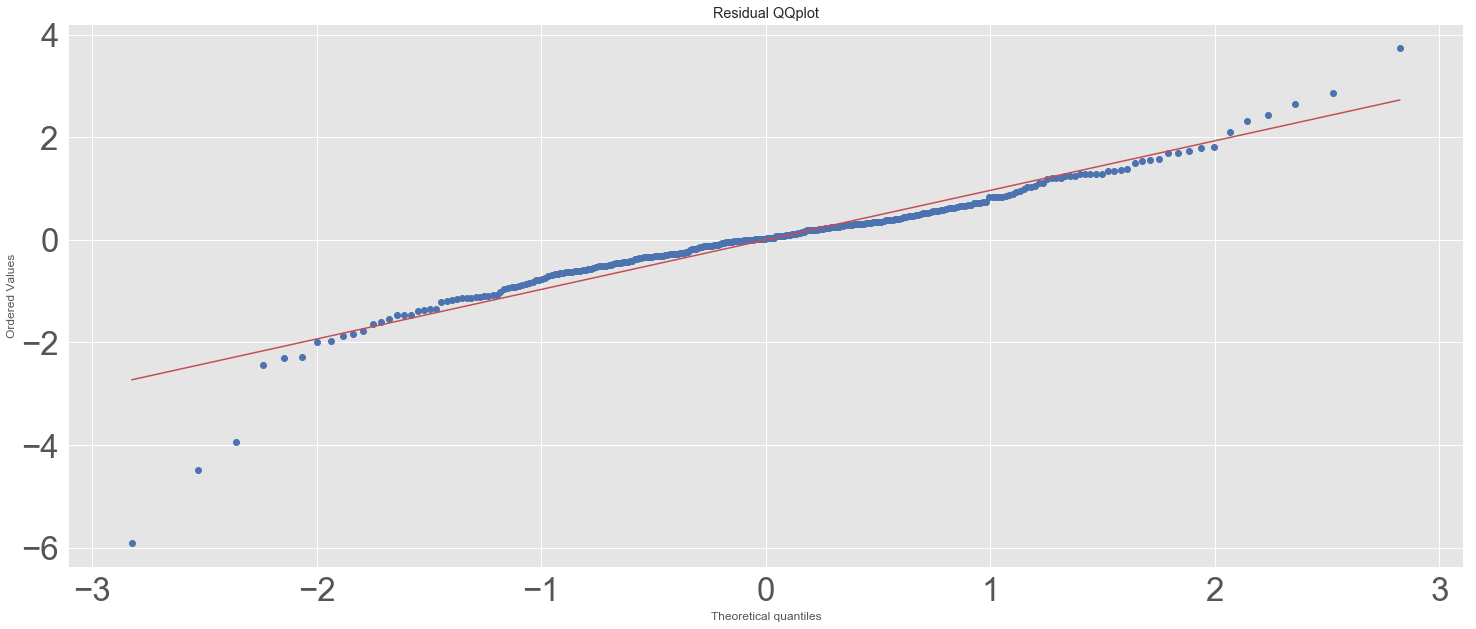

In [41]:
plot_residuals(final_reg,data_preproc_x_test,data_preproc_y_test)
plt.show()
qqplot_residuals(final_reg,data_preproc_x_test, data_preproc_y_test)
plt.show()

We can see that the stacked model have further reduced the RMSE of our prediction. However we can see in the residuals plots that the metalearner keeps failing at predicting some points which were not well predicted by the other regressors.

To reduce the residuals on this kind of points we will average the models prediction in function of the residuals correlations : the models wich are the less correlated will have less weights whereas the other will have more weights. It will lead, in my opinion, to more robust regression predictions

### 10) Averaging uncorrelated models

#### Correlation matrix of the residuals

In [42]:
all_regressors = [('xgb', model_xgb),
                 ('rf', model_rf),
                ('svr', model_svr),
                ('enet',model_enet),
                 ('stack', final_reg)]
residuals = []
for name,model in all_regressors:
    #model.fit(data_preproc_x,data_preproc_y)
    residuals.append(data_preproc_y - model.predict(data_preproc_x))
residuals = np.array(residuals).T


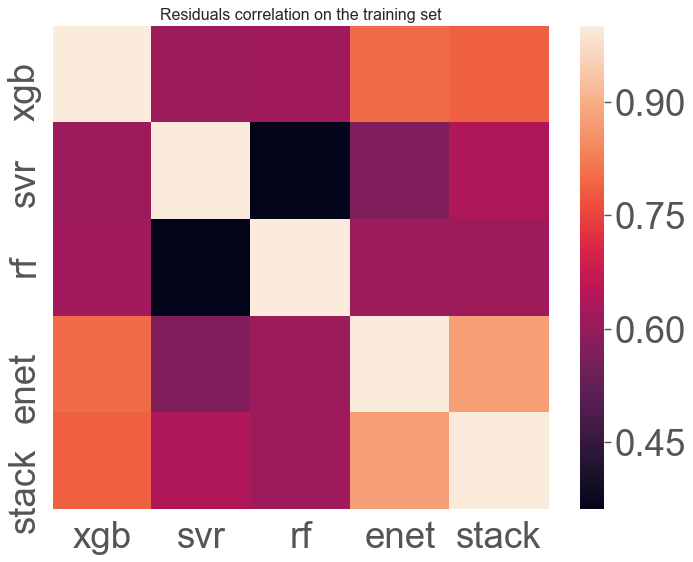

In [43]:
df = pd.DataFrame(residuals,columns = ['xgb','svr','rf','enet','stack'])
corrMatrix = df.corr()
plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.title("Residuals correlation on the training set")
sns.heatmap(corrMatrix, annot=False)

As we can see the svr and rf seems to be less correlated to the other models. However the rf model predicts quite badly the log of price so we will put a a lot of weigth in the svr in our final predictions. 

### Final predictions and submission

<u> Transforming the submission set</u>

In [44]:
sub = pd.read_csv('test.csv')
sub = Change_index(sub)
sub = Manual_NA_correction(sub)
sub = manual_features(sub)
sub = add_poly(sub, top.iloc[1:].index)
sub = pd.DataFrame(preproc_full_x.transform(sub), columns = np.array(data_preproc_full_x.columns),index =sub.index)


In [45]:
all_regressors = [('xgb', model_xgb,0.2),#list([Model_Name,Model,Weight_final_pred])
                 ('rf', model_rf,0.05),
                ('svr', model_svr,0.4),
                ('enet',model_enet,0.2),
                 ('stack', final_reg,0.15)]
preds = []
for name,model,w in all_regressors:
    model.fit(data_preproc_full_x, data_preproc_full_y)
    #print(np.isnan(np.expm1(model.predict(sub))).sum())
    preds.append(w* np.expm1(np.clip(model.predict(sub),0,13.05)))#The svr returned some inf predictions so i decided to clip to the max variable of the traning set
fi = np.array(preds).T.sum(axis = 1)

In [46]:
submission = pd.DataFrame(fi,columns = ['SalePrice'] , index = sub.index)
submission.to_csv('final_submission2.csv')